<a href="https://colab.research.google.com/github/bahereh/Data-Science-Projects/blob/master/InflastionEstimationIRAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
tf.random.set_seed(7)
dataframe = pd.read_csv('KPI_EN.csv', usecols=[1], engine='python')
dataframe2 = pd.read_csv('KPI_EN.csv', usecols=[0], engine='python')
date = dataframe2.values.astype('str')
dataset = dataframe.values
dataset = dataset.astype('float32')


['2016-1']
<class 'list'>


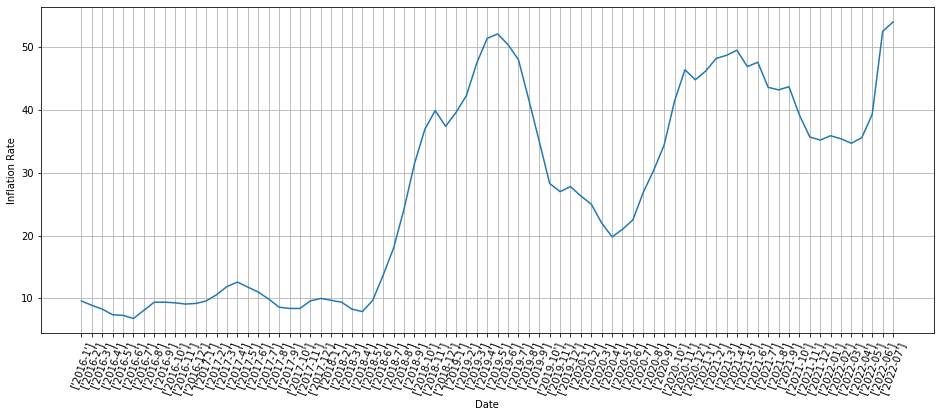

In [136]:
x = list(dataframe2.values)
print(x[0])
print(type(x))

plt.figure(figsize=(16, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.xticks([i for i in range(len(dataset))], x, rotation=70)  # Set text labels and properties.
plt.ylabel('Commodity price')
plt.ylabel('Inflation Rate')
plt.grid()
plt.show()

In [137]:
# dataset = dataset[75:]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #
print(len(dataset))
dataset = scaler.fit_transform(dataset) #.reshape(-1,1)
# dataset is between 0,1

# split into train and test sets
train_size = int(len(dataset) * 0.77)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# convert an array of values into a dataset matrix
import numpy as np
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

79
60 19


In [138]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(30,return_sequences=True,input_shape=(look_back,1)))
model.add(LSTM(30,return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1)) # Final output
model.compile(loss='mean_squared_error', optimizer='adam')

In [139]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 30)            3840      
                                                                 
 lstm_16 (LSTM)              (None, 10, 30)            7320      
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
49/49 - 4s - loss: 0.1001 - 4s/epoch - 90ms/step
Epoch 2/100
49/49 - 0s - loss: 0.0705 - 393ms/epoch - 8ms/step
Epoch 3/100
49/49 - 0s - loss: 0.0672 - 376ms/epoch - 8ms/step
Epoch 4/100
49/49 - 0s - loss: 0.0584 - 405ms/epoch - 8ms/step
Epoch 5/100
49/49 - 0s - loss: 0.0603 - 407ms/epoch - 8ms/step
Epoch 6/100
49/49 - 0s - loss: 0.0514 - 397ms/epoch - 8ms/step
Epoch 7/100
49/49 - 0s - loss: 0.0401 - 395ms/epoch - 8ms/step
Epoch 8/100
49/49 - 0s - loss: 0.0241 - 387ms/epoch - 8ms/step
Epoch 9/100
49/49 - 0s - loss: 0.0236 - 381ms/epoch - 8ms/step
Epoch 10/100
49/49 - 0s - loss: 0.0204 - 400ms/epoch - 8ms/step
Epoch 11/100
49/49 - 0s - loss: 0.0186 - 385ms/epoch - 8ms/step
Epoch 12/100
49/49 - 0s - loss: 0.0329 - 398ms/epoch - 8ms/step
Epoch 13/100
49/49 - 0s - loss: 0.0171 - 393ms/epoch - 8ms/step
Epoch 14/100
49/49 - 0s - loss: 0.0152 - 398ms/epoch - 8ms/step
Epoch 15/100
49/49 - 0s - loss: 0.0176 - 402ms/epoch - 8ms/step
Epoch 16/100
49/49 - 0s - loss: 0.0176 - 417ms/epoc

In [141]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.68 RMSE
Test Score: 5.26 RMSE


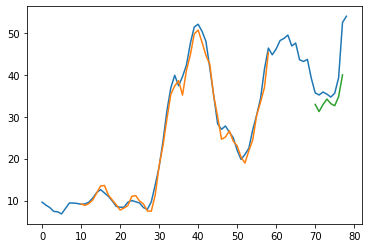

In [142]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# [USING THE TRAINED MODEL]

In [143]:
#Predict the future 12 month
x_input=test[len(test)-look_back:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist() # take all the values


In [144]:
# demonstrate prediction for next 12 months
from numpy import array
duration = 12
print(len(temp_input), temp_input, type(temp_input))
xxx = len(temp_input)
lst_output=[]
n_steps=look_back
i=0
while(i<duration): # FORECASTING #) DAYS
    
    if(xxx>look_back):
      #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
        xxx = len(list(temp_input))
    else:
      print('FIRST')
      x_input = x_input.reshape((1, n_steps,1))
      print(x_input)
      yhat = model.predict(x_input, verbose=0)
      temp_input.extend(yhat[0].tolist())
      print(len(temp_input))
      lst_output.extend(yhat.tolist())
      xxx = len(list(temp_input))
      i=i+1
    

print(lst_output)

10 [0.6864407062530518, 0.6122881174087524, 0.6016949415206909, 0.6165254712104797, 0.6059322357177734, 0.5911017060279846, 0.6101694703102112, 0.6885592937469482, 0.9682202935218811, 0.9999999403953552] <class 'list'>
FIRST
[[[0.6864407 ]
  [0.6122881 ]
  [0.60169494]
  [0.6165255 ]
  [0.60593224]
  [0.5911017 ]
  [0.6101695 ]
  [0.6885593 ]
  [0.9682203 ]
  [0.99999994]]]
11
1 day input [0.61228812 0.60169494 0.61652547 0.60593224 0.59110171 0.61016947
 0.68855929 0.96822029 0.99999994 0.89100951]
1 day output [[0.7200763]]
2 day input [0.60169494 0.61652547 0.60593224 0.59110171 0.61016947 0.68855929
 0.96822029 0.99999994 0.89100951 0.72007632]
2 day output [[0.59795517]]
3 day input [0.61652547 0.60593224 0.59110171 0.61016947 0.68855929 0.96822029
 0.99999994 0.89100951 0.72007632 0.59795517]
3 day output [[0.5365211]]
4 day input [0.60593224 0.59110171 0.61016947 0.68855929 0.96822029 0.99999994
 0.89100951 0.72007632 0.59795517 0.53652108]
4 day output [[0.50406516]]
5 day inpu

In [145]:
print('THE PREDICTED DOLLAR VALUE IS: ')
print(scaler.inverse_transform(lst_output))
print(len(lst_output))
tmp=test[len(test)-look_back:].reshape(1,-1)
tmp.shape
temp = list(tmp)
temp = temp[0].tolist() # take all the values


THE PREDICTED DOLLAR VALUE IS: 
[[48.85564827]
 [40.78760204]
 [35.02348365]
 [32.12379466]
 [30.59187522]
 [29.09053818]
 [27.09101363]
 [24.74515437]
 [22.52176259]
 [21.05369609]
 [20.55148833]
 [20.9134849 ]]
12


79


Text(0.5, 0, 'Date')

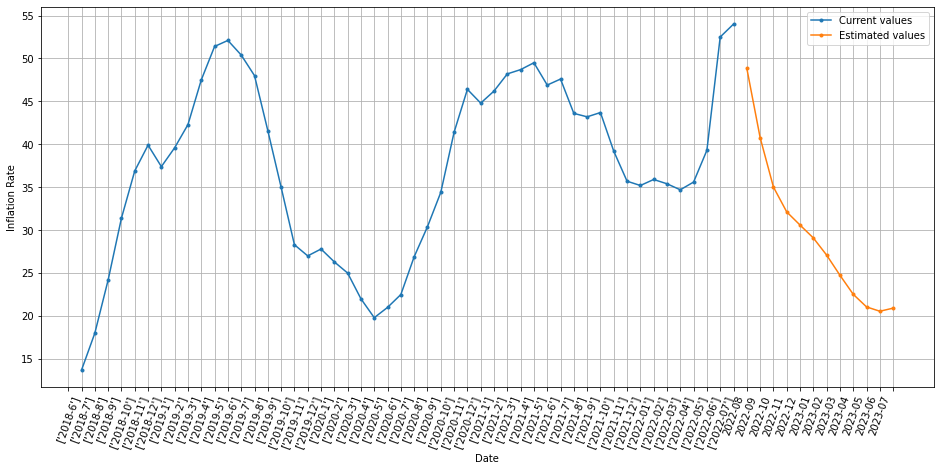

In [153]:
dataset3 = dataframe.values.astype('float32')
day_new=np.arange(1,51)
day_pred=np.arange(51,51+duration)
import matplotlib.pyplot as plt
print(len(dataset))
plt.figure(figsize=(16, 7))
y = x.copy()
names = ['2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07']
y= y[-50:] + names 
plt.grid()
plt.plot(day_new,scaler.inverse_transform(dataset[len(dataset)-50:]),marker = '.')
plt.plot(day_pred,scaler.inverse_transform(lst_output),marker = '.')
plt.legend(['Current values','Estimated values'])
plt.xticks([i for i in range(51+duration)], y, rotation=70)  # Set text labels and properties.
plt.ylabel('Inflation Rate')
plt.xlabel('Date')

In [147]:
print(scaler.inverse_transform(lst_output) -dataset3[-12:] )

[[  5.65564751]
 [ -2.91239873]
 [ -4.17651712]
 [ -3.5762061 ]
 [ -4.60812555]
 [ -6.80946335]
 [ -8.30898789]
 [ -9.95484639]
 [-13.07823589]
 [-18.24630314]
 [-31.94851167]
 [-33.0865151 ]]
